# Исследование NPS в продуктах МТС

In [3]:
import pandas as pd
import numpy as np

import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

In [22]:
sns.set(
    font_scale =2,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,7)}
)

In [5]:
df = pd.read_excel(r"C:\Users\anton\Downloads\Антон Бараненков Тестовое МТС Клиентский опыт\nps_data.xlsx")

# Сначала проведём разведывательный анализ данных

In [23]:
df
#колонки названы нормально

product age_group  geo_group lifetime_group  nps_score  nps_group
0             Связь     36-50        1M+       6 months          9   Promoter
1             URent     36-50    500K-1M       3+ years          9   Promoter
2         MTC Music     36-50  МСК и СПБ       3+ years          9   Promoter
3             URent     36-50  МСК и СПБ       3+ years         10   Promoter
4             URent       50+  МСК и СПБ       3+ years          1  Detractor
...             ...       ...        ...            ...        ...        ...
249995        URent     26-35  МСК и СПБ       3+ years          9   Promoter
249996  MTC Premium     26-35      0-10K         1 year         10   Promoter
249997        Связь     26-35  МСК и СПБ        1 month         10   Promoter
249998          MWS     36-50        1M+       3+ years          4  Detractor
249999  MTC Premium     18-25   10K-100K       3+ years          9   Promoter

[250000 rows x 6 columns]

In [24]:
df.isna().sum()

product           0
age_group         0
geo_group         0
lifetime_group    0
nps_score         0
nps_group         0
dtype: int64

In [25]:
df.dtypes

product             object
age_group           object
geo_group           object
lifetime_group      object
nps_score            int64
nps_group         category
dtype: object

In [26]:
df.apply(pd.Series.unique)

product                 [Связь, URent, MTC Music, MTC Premium, MWS]
age_group                                [36-50, 50+, 26-35, 18-25]
geo_group         [1M+, 500K-1M, МСК и СПБ, 100K-500K, 0-10K, 10...
lifetime_group     [6 months, 3+ years, 1 month, 1-3 years, 1 year]
nps_score                           [9, 10, 1, 7, 2, 6, 4, 5, 8, 3]
nps_group         ['Promoter', 'Detractor', 'Passive']
Categorie...
dtype: object

In [27]:
df.describe()

nps_score
count  250000.000000
mean        8.686484
std         1.898329
min         1.000000
25%         9.000000
50%         9.000000
75%        10.000000
max        10.000000

С данными всё в порядке, пропусков нет, типы верные, значения записаны правильно

In [28]:
#создадим категориальную колонку nps
df['nps_group'] = pd.cut(df['nps_score'], bins=[-1, 6, 8, 10], labels=['Detractor', 'Passive', 'Promoter'])

In [29]:
df

product age_group  geo_group lifetime_group  nps_score  nps_group
0             Связь     36-50        1M+       6 months          9   Promoter
1             URent     36-50    500K-1M       3+ years          9   Promoter
2         MTC Music     36-50  МСК и СПБ       3+ years          9   Promoter
3             URent     36-50  МСК и СПБ       3+ years         10   Promoter
4             URent       50+  МСК и СПБ       3+ years          1  Detractor
...             ...       ...        ...            ...        ...        ...
249995        URent     26-35  МСК и СПБ       3+ years          9   Promoter
249996  MTC Premium     26-35      0-10K         1 year         10   Promoter
249997        Связь     26-35  МСК и СПБ        1 month         10   Promoter
249998          MWS     36-50        1M+       3+ years          4  Detractor
249999  MTC Premium     18-25   10K-100K       3+ years          9   Promoter

[250000 rows x 6 columns]

In [30]:
df.nps_group.value_counts(normalize = True)

nps_group
Promoter     0.757240
Passive      0.143208
Detractor    0.099552
Name: proportion, dtype: float64

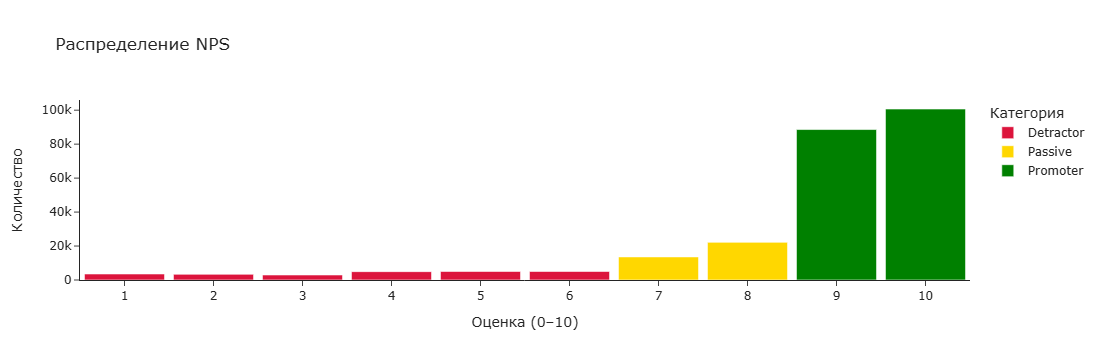

In [31]:
fig = px.histogram(
    df,
    x='nps_score',
    color='nps_group',
    category_orders={'nps_group': ['Detractor', 'Passive', 'Promoter']},
    nbins=11,
    title='Распределение NPS',
    color_discrete_map={
        'Detractor': 'crimson',
        'Passive': 'gold',
        'Promoter': 'green'
    },
    labels={'nps_score': 'Оценка', 'nps_group': 'Категория'}
)

fig.update_layout(
    bargap=0.1,
    xaxis=dict(dtick=1),
    yaxis_title='Количество',
    xaxis_title='Оценка (0–10)',
    template='simple_white'
)

fig.show()

# Теперь проведем стандартный когортный анализ
## Нас интересуют аномальные значения nps (в особенности аномально низкие)

In [32]:
df.columns

Index(['product', 'age_group', 'geo_group', 'lifetime_group', 'nps_score',
       'nps_group'],
      dtype='object')

In [33]:
def calc_nps(sub_df):
    promoters = (sub_df['nps_group'] == 'Promoter').sum()
    detractors = (sub_df['nps_group'] == 'Detractor').sum()
    return (promoters - detractors) / len(sub_df) * 100

results = []
for factor in ['product', 'age_group', 'geo_group', 'lifetime_group']:
    for cogort_name, cogort_df in df.groupby(factor):
        nps_score = calc_nps(cogort_df)
        results.append({
            'factor': factor,
            'group': cogort_name,
            'nps': round(nps_score, 2),
            'count': len(cogort_df)
        })

cogort_analysis = pd.DataFrame(results).sort_values(by = ['factor', 'nps'])
cogort_analysis.set_index(['factor', 'group'], inplace=True)

In [34]:
cogort_analysis

nps   count
factor         group                     
age_group      50+          52.43   36005
               26-35        67.73  106907
               36-50        67.73   71385
               18-25        69.44   35703
geo_group      10K-100K     64.08   20709
               100K-500K    64.23   42033
               0-10K        64.70   20728
               500K-1M      64.91   41585
               1M+          66.91   62412
               МСК и СПБ    67.15   62533
lifetime_group 1 month      55.57   20854
               6 months     56.17   41582
               1 year       56.33   41580
               1-3 years    68.82   62662
               3+ years     75.53   83322
product        URent        57.82   46793
               MTC Music    60.06   47249
               MWS          67.78   15859
               MTC Premium  67.92   62078
               Связь        71.87   78021

### Что мы видим?
**Age_group**: в глаза бросается аномально низкое значение NPS в категории 50+ лет (52 против 67-69 в среднем)

Возможные причины: слабая цифровая вовлечённость, неудовлетворённость интерфейсом/сервисом, иные ожидания от продукта;

**Geo_group**: чем крупнее населённый пункт, тем выше NPS

Можно предположить, что в крупных городах выше качество инфраструктуры и обслуживания, более «продвинутая» аудитория;

**Lifetime_group**: явная закономерность: чем дольше клиент, тем выше его лояльность

Возможно, новые клиенты сталкиваются с неожиданными трудностями, потому что я сильно сомневаюсь, что люди со временем влюбляются в компанию;

**Product**: URent (57.82) и MTC Music (60.06) — имеют наиболее низкий NPS, MWS имеет высокий NPS (67.78), но относительно маленькое количество пользователей (15 859)

Видимо пользователи URent и MTC Music попросту недовольны продуктом.

Для проверки статистической значимости различий и аномалий можно применить критерий хи-квадрат, но с такими большими выборками и так понятно что аномальные значения не случайны.

# Поробуем выяснить причины отклонений

### Начнем с категории 50+

In [35]:
df_50 = df.query("age_group == '50+'").drop(columns = {'age_group'})
df_50

product  geo_group lifetime_group  nps_score  nps_group
4             URent  МСК и СПБ       3+ years          1  Detractor
14            Связь  МСК и СПБ         1 year          7    Passive
15      MTC Premium  МСК и СПБ       3+ years          9   Promoter
16      MTC Premium   10K-100K         1 year          2  Detractor
17              MWS        1M+       3+ years          9   Promoter
...             ...        ...            ...        ...        ...
249959    MTC Music  100K-500K       3+ years          9   Promoter
249960        Связь   10K-100K       3+ years          3  Detractor
249965        Связь  МСК и СПБ       3+ years          9   Promoter
249966    MTC Music    500K-1M       3+ years          9   Promoter
249970        Связь   10K-100K         1 year         10   Promoter

[36005 rows x 5 columns]

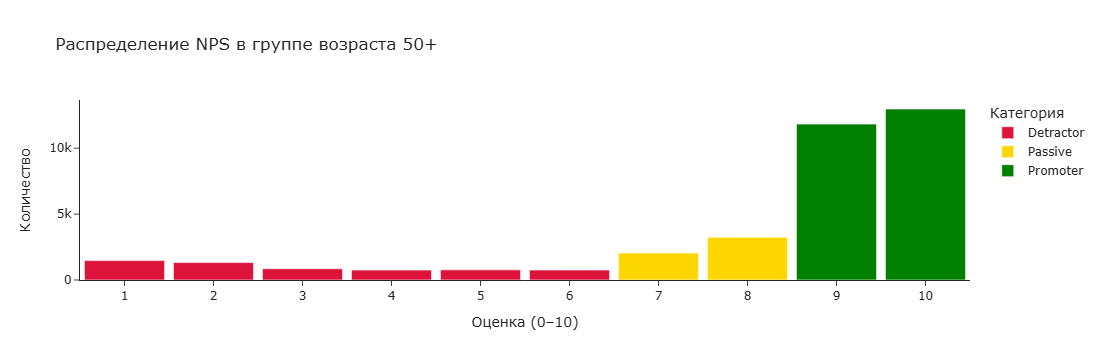

In [36]:
fig = px.histogram(
    df_50,
    x='nps_score',
    color='nps_group',
    category_orders={'nps_group': ['Detractor', 'Passive', 'Promoter']},
    nbins=11,
    title='Распределение NPS в группе возраста 50+',
    color_discrete_map={
        'Detractor': 'crimson',
        'Passive': 'gold',
        'Promoter': 'green'
    },
    labels={'nps_score': 'Оценка', 'nps_group': 'Категория'}
)

fig.update_layout(
    bargap=0.1,
    xaxis=dict(dtick=1),
    yaxis_title='Количество',
    xaxis_title='Оценка (0–10)',
    template='simple_white'
)

fig.show()

In [37]:
#попробуем понять на что жалуются клиенты данной группы
results_50 = []
for factor in ['product', 'geo_group', 'lifetime_group']:
    for cogort_name, cogort_df in df_50.groupby(factor):
        nps_score = calc_nps(cogort_df)
        results_50.append({
            'factor': factor,
            'group': cogort_name,
            'nps': round(nps_score, 2),
            'count': len(cogort_df)
        })

cogort_analysis_50 = pd.DataFrame(results_50).sort_values(by = ['factor', 'nps'])
cogort_analysis_50.set_index(['factor', 'group'], inplace=True)

cogort_analysis_50

nps  count
factor         group                    
geo_group      10K-100K     50.20   2966
               0-10K        50.37   2994
               500K-1M      51.19   6038
               100K-500K    51.71   6022
               1M+          53.51   8942
               МСК и СПБ    54.07   9043
lifetime_group 1 month      37.56   3030
               6 months     37.57   5933
               1 year       38.04   5981
               1-3 years    57.53   9117
               3+ years     66.90  11944
product        URent       -14.01   6674
               MTC Music    60.87   6821
               MTC Premium  66.72   9029
               MWS          67.69   2247
               Связь        72.24  11234

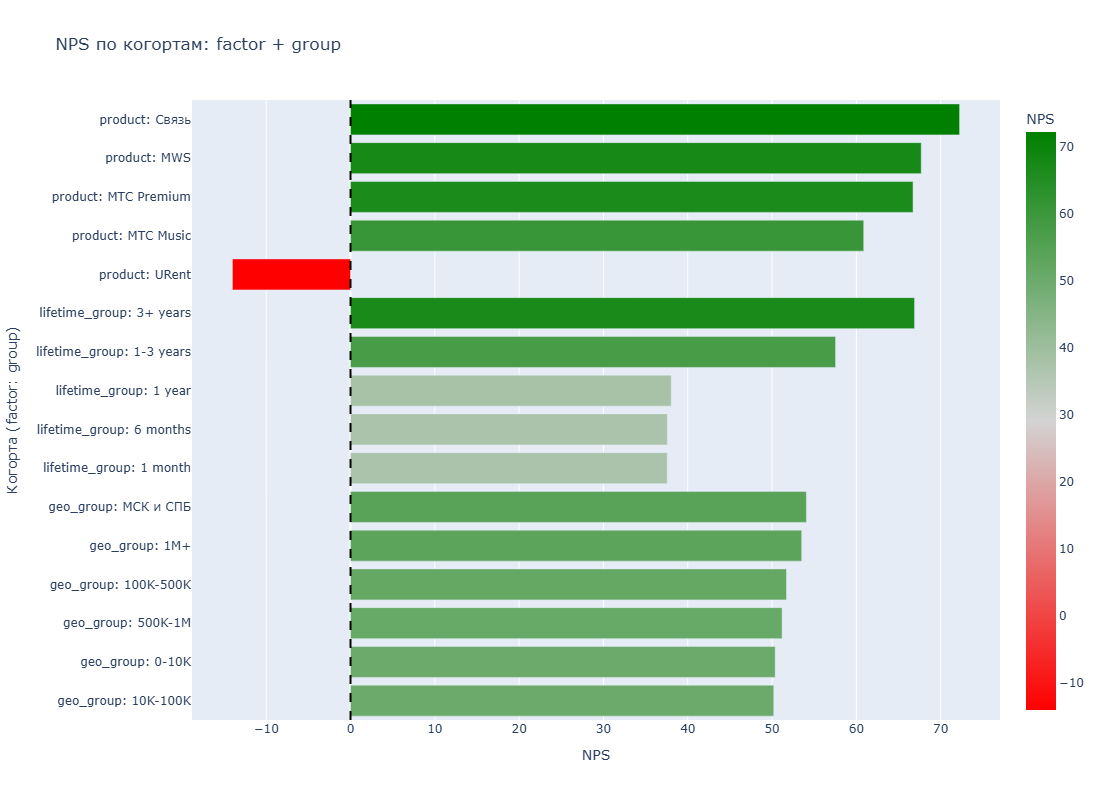

In [51]:
df_plot = cogort_analysis_50.reset_index()

# Создаём категориальный порядок, чтобы фактор группировался красиво
df_plot['group_label'] = df_plot['factor'] + ': ' + df_plot['group']

# Сортируем по factor и nps для красивого отображения
df_plot = df_plot.sort_values(by=["factor", "nps"])

# Создаём горизонтальный barplot
fig = px.bar(
    df_plot,
    x='nps',
    y='group_label',
    color='nps',
    color_continuous_scale=[(0.0, 'red'), (0.5, 'lightgrey'), (1.0, 'green')],
    orientation='h',
    hover_data=['count'],
    title='NPS по когортам: factor + group'
)

# Добавим вертикальную линию на уровне NPS=0
fig.add_vline(x=0, line_dash="dash", line_color="black")

# Стилизация
fig.update_layout(
    yaxis=dict(tickfont=dict(size=12)),
    xaxis_title='NPS',
    yaxis_title='Когорта (factor: group)',
    coloraxis_colorbar=dict(title='NPS'),
    height=800
)

fig.show()

#### Теперь мы знаем точно, что пользователи возраста 50+ ненавидят самокаты (NPS = -14.01)
Также в этой возрастной группе наблюдаются проблемы в течение первого года использования продуктов МТС

In [212]:
#проверим, верно ли найдена причина отклонения, убрав строки с продуктом URent & возрастом 50+

In [213]:
temp_df = df[~((df['age_group'] == '50+') & (df['product'] == 'URent'))]

results_temp = []
for factor in ['product', 'age_group', 'geo_group', 'lifetime_group']:
    for cogort_name, cogort_df in temp_df.groupby(factor):
        nps_score = calc_nps(cogort_df)
        results_temp.append({
            'factor': factor,
            'group': cogort_name,
            'nps': round(nps_score, 2),
            'count': len(cogort_df)
        })

cogort_analysis_check = pd.DataFrame(results_temp).sort_values(by = ['factor', 'nps'])
cogort_analysis_check.set_index(['factor', 'group'], inplace=True)
cogort_analysis_check

nps   count
factor         group                     
age_group      50+          67.55   29331
               26-35        67.73  106907
               36-50        67.73   71385
               18-25        69.44   35703
geo_group      10K-100K     66.29   20165
               100K-500K    66.33   40908
               0-10K        66.97   20154
               500K-1M      66.99   40514
               1M+          69.14   60748
               МСК и СПБ    69.39   60837
lifetime_group 1 month      58.77   20266
               6 months     59.10   40522
               1 year       59.42   40423
               1-3 years    70.61   61072
               3+ years     76.94   81043
product        MTC Music    60.06   47249
               MWS          67.78   15859
               MTC Premium  67.92   62078
               URent        69.77   40119
               Связь        71.87   78021

#### Теперь отклонений в этой возрастной группе не наблюдается

### Выясним, чем недовольны новые клиенты (срок использования до года включительно)

In [214]:
young_clients = df[df['lifetime_group'].isin(['6 months', '1 month', '1 year'])]

In [215]:
young_clients

product age_group  geo_group lifetime_group  nps_score nps_group
0             Связь     36-50        1M+       6 months          9  Promoter
5         MTC Music     26-35  100K-500K       6 months          9  Promoter
7             Связь     36-50      0-10K        1 month          7   Passive
10            URent     18-25        1M+        1 month         10  Promoter
14            Связь       50+  МСК и СПБ         1 year          7   Passive
...             ...       ...        ...            ...        ...       ...
249987    MTC Music     26-35  МСК и СПБ       6 months          9  Promoter
249988    MTC Music     26-35        1M+         1 year          9  Promoter
249990    MTC Music     18-25   10K-100K        1 month          7   Passive
249996  MTC Premium     26-35      0-10K         1 year         10  Promoter
249997        Связь     26-35  МСК и СПБ        1 month         10  Promoter

[104016 rows x 6 columns]

In [216]:
#опять проводим когортный анализ
results_young = []
for factor in ['product', 'age_group', 'geo_group', 'lifetime_group']:
    for cogort_name, cogort_df in young_clients.groupby(factor):
        nps_score = calc_nps(cogort_df)
        results_young.append({
            'factor': factor,
            'group': cogort_name,
            'nps': round(nps_score, 2),
            'count': len(cogort_df)
        })

cogort_analysis_young = pd.DataFrame(results_young).sort_values(by = ['factor', 'nps'])
cogort_analysis_young.set_index(['factor', 'group'], inplace=True)
cogort_analysis_young

nps  count
factor         group                    
age_group      50+          37.75  14944
               36-50        58.50  29938
               26-35        58.84  44263
               18-25        61.64  14871
geo_group      100K-500K    54.01  17435
               10K-100K     54.20   8614
               500K-1M      54.31  17269
               0-10K        54.64   8564
               1M+          57.85  26127
               МСК и СПБ    58.11  26007
lifetime_group 1 month      55.57  20854
               6 months     56.17  41582
               1 year       56.33  41580
product        URent        44.60  19543
               MTC Music    52.17  19810
               MWS          56.89   6530
               MTC Premium  57.76  25810
               Связь        64.03  32323

#### Новые клиенты особенно недовольны самокатами, в остальном -- ничего нового

### Выясним, почему у MTC Music такой низкий NPS (потому что у URent уже выяснили)

In [217]:
selected = df[df['product'] == 'MTC Music'].drop(columns = {'product'})

In [218]:
#когортный анализ
results_selected = []
for factor in ['age_group', 'geo_group', 'lifetime_group']:
    for cogort_name, cogort_df in selected.groupby(factor):
        nps_score = calc_nps(cogort_df)
        results_selected.append({
            'factor': factor,
            'group': cogort_name,
            'nps': round(nps_score, 2),
            'count': len(cogort_df)
        })

cogort_analysis_selected = pd.DataFrame(results_selected).sort_values(by = ['factor', 'nps'])
cogort_analysis_selected.set_index(['factor', 'group'], inplace=True)
cogort_analysis_selected

nps  count
factor         group                  
age_group      36-50      59.36  13338
               18-25      59.95   6662
               26-35      60.28  20428
               50+        60.87   6821
geo_group      10K-100K   59.38   3890
               1M+        59.57  11823
               100K-500K  59.90   8029
               0-10K      60.23   3955
               МСК и СПБ  60.50  11771
               500K-1M    60.53   7781
lifetime_group 6 months   51.69   7881
               1 year     52.15   7897
               1 month    53.12   4032
               1-3 years  61.54  11738
               3+ years   68.91  15701

#### В данном случае не получилось выяснить источник аномалий, у MTC Music стабильно низкая оценка вне зависимости от когорты

# Выводы

Причиной аномально низкого NPS в категории 50+ лет оказался сервис URent, которому данная возрастная категория поставила низкие оценки

Новые пользователи сильнее недовольны самокатами относительно более давних клиентов

MTC Music пользователи в среднем оценивают хуже остальных продуктов МТС внезависимости от когорты

# Предложения

| Что анализировать   | Почему важно                        | Что можно делать                                  |
| ------------------- | ----------------------------------- | ------------------------------------------------- |
| Возраст 50+         | Явный outlier, недовольны           | User research, интервью, улучшить UX              |
| MWS и MTC Premium   | Высокий NPS, маленький охват        | Рассмотреть масштабирование                       |
| Новички (1–6 мес)   | Слабый NPS                          | Посмотреть первые касания, welcome-flow           |
| Связь — топ продукт | Самый высокий NPS                   | Понять сильные стороны, использовать как референс |
| Региональные группы | Стабильный NPS даже вне мегаполисов | Усиливать маркетинг в регионах                    |
